# Evaluating Moving Average Strategies using Python

Kenneth Burchfiel

MIT License

February 22, 2021
(Updated on March 11, 2021)

Acknowledgements: I am grateful to Mattan Griffel, my Intro to Python professor, for his code examples and lectures, which played a role in the development of this progam.

## Note: Some graphs/tables are not displaying correctly on GitHub. Therefore, I recommend either viewing the .pdf output of this file or downloading the ipynb file and related code.

**Disclaimer: I am not a financial advisor, and this program should not be used as investing advice!**

**Disclaimer 2: My analyses of the trading strategies in this program are based on the data that the Alpha Vantage API retrieved  in February 2021. The program will return more recent data if it is run in the future, so the conclusions I make below will likely become less applicable over time.**


1. I'll start by importing various libraries and reading my Alpha Vantage api key into memory. You will need to change the file path to link to your own API key for the formula to work.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from alpha_vantage.timeseries import TimeSeries
with open('..\\keys\\alphavantageapi.txt') as file: 
    alphavantage_api_key = file.read() 

2. Next, I'll define a function that converts a ticker into a Pandas DataFrame that contains adjusted close prices and percent changes. 
The length of the list is specified by the 'rowcount' argument.

In [2]:
def get_clean_df(ticker,rowcount=1000,rowlimit=True):       
    ts = TimeSeries(key=alphavantage_api_key, output_format='pandas')
    df, meta_data = ts.get_daily_adjusted(ticker, outputsize='full') # get_daily_adjusted takes stock splits 
    # into account. outputsize='full' increases the number of dates the function will return.
    df.sort_values('date', inplace=True) # I want the default (ascending = True) to be used in this case
    df.drop(columns=['1. open', '2. high', '3. low', '4. close', '6. volume', '7. dividend amount', 
                     '8. split coefficient'],inplace=True) 
    # the only column I'll need, so I dropped the others.
    close_column_name = ticker+'_close' # Incorporating the ticker into the close price column will make it
    # easier to keep track of DataFrames for different stocks.
    df.columns=[close_column_name]
    df['pct_change']=df[close_column_name].pct_change() # Calculates the daily percentage change for each stock
    if rowlimit == True:
        return df.iloc[-1*rowcount:] # Returns the last (rowcount) number of rows.
        # Source: https://www.kite.com/python/answers/how-to-get-the-last-n-rows-from-a-pandas-dataframe-in-python . 
        # Using .tail(rowcount) should also work
    else:
        return df # i.e. return all rows generated by ts.get_daily_adjusted


3. I will now use the get_clean_df function to retrieve 5 sets of stock close data from Alpha Vantage and store each of them in a list of DataFrames. 

In [3]:
stocks_list = ['MDT', 'V', 'MDLZ', 'LOW', 'ZBH'] # Medtronic, Visa, Mondelez, Lowe's, and 
# Zimmer Biomet Holdings, respectively. 
# These are the top 5 stocks held by AVEDX, one of my favorite mutual funds.

df_list = [] # This list will store 5 DataFrames, one generated for each stock ticker using 
# the get_clean_df function created above.

for stock in stocks_list:
    df_list.append(get_clean_df(stock,1260,True)) # I chose 1260 in order to gather data 
    # for the past 5 years (2016-02-19 to 2021-2-20 at the time I created the program). There are about 
    # 253 trading days per year (https://en.wikipedia.org/wiki/Trading_day )
    print("appended",stock) # Keeps track of the program's process
    filename = stock+'_stock_data.csv' 
    df_list[-1].to_csv(filename) # Storing the files to a CSV is useful in the event that the 
    # daily limit for Alpha Vantage API calls is reached.
    # df_list[-1] stores the most recent DataFrame, which will correspond to the DataFrame that
    # was just appended into df_list.

print(len(df_list)) # Verifies that all tickers were added to the list

df_list

appended MDT
appended V
appended MDLZ
appended LOW
appended ZBH
5


[             MDT_close  pct_change
 date                              
 2016-03-10   68.388908    0.009530
 2016-03-11   69.357310    0.014160
 2016-03-14   69.518710    0.002327
 2016-03-15   68.908976   -0.008771
 2016-03-16   68.729642   -0.002602
 ...                ...         ...
 2021-03-05  118.260000    0.025939
 2021-03-08  116.670000   -0.013445
 2021-03-09  117.050000    0.003257
 2021-03-10  118.660000    0.013755
 2021-03-11  118.100000   -0.004719
 
 [1260 rows x 2 columns],
                V_close  pct_change
 date                              
 2016-03-10   67.922520   -0.006508
 2016-03-11   69.286387    0.020080
 2016-03-14   69.150968   -0.001954
 2016-03-15   69.557226    0.005875
 2016-03-16   70.002176    0.006397
 ...                ...         ...
 2021-03-05  215.410000    0.018487
 2021-03-08  220.270000    0.022562
 2021-03-09  220.360000    0.000409
 2021-03-10  223.170000    0.012752
 2021-03-11  226.150000    0.013353
 
 [1260 rows x 2 columns],
        

4. I'll now define a function that, given a DataFrame and a period length, creates a copy of that DataFrame; adds a moving average for that 
period length to that DataFrame; and also reports whether the daily close price was above or below that DataFrame. This function will be called 
200 times later in the program.

In [4]:
def add_moving_avg(df,periods=50):
    df_ma = df.copy() # copy() prevents changes to the DataFrame within this function from affecting the 
    # original DataFrame. Source: https://stackoverflow.com/a/27680109/13097194
    ma_column_name = str(periods)+"_day_ma" # ma = moving average
    # print ("ma_column_name is",ma_column_name) # for debugging
    df_ma[ma_column_name]=df_ma.iloc[:,0].rolling(periods, periods).mean() # Returns a moving average 
    # for 'periods' days for all rows that have at least 'periods' days of data available. iloc[:,0] refers
    # to all rows for the first column, which contains close price information. iloc
    # is used frequently in this program because it works well with columns in different DataFrames 
    # that have the same location within their DataFrame but different names.
    df_ma.dropna(inplace=True) # Depending on the size of 'periods', multiple rows at the start 
    # of the DataFrame may have a moving average of 'NaN' because not enough price data is available 
    # to compute the moving average for that row. dropna() removes those rows.
    close_above_ma_column_name = "close_above_"+ma_column_name
    df_ma[close_above_ma_column_name]=df_ma.iloc[:,0] > df_ma[ma_column_name] # Returns True if the close
    # price (stored in column 0) is above the 
    # DataFrame and False otherwise. 
    return df_ma

add_moving_avg(df_list[0],100) # An example of this function's output for the first stock 
# in df_list (MDT) using a 100-day moving average

,MDT_close,pct_change,100_day_ma,close_above_100_day_ma
date,,,,
2016-08-01,79.751243,0.004907,73.561423,True
2016-08-02,79.370872,-0.004769,73.671242,True
2016-08-03,78.492394,-0.011068,73.762593,True
2016-08-04,78.573902,0.001038,73.853145,True
2016-08-05,78.872766,0.003804,73.952783,True
...,...,...,...,...
2021-03-05,118.260000,0.025939,113.136053,True
2021-03-08,116.670000,-0.013445,113.217652,True
2021-03-09,117.050000,0.003257,113.324144,True


5. 

**This is a good time to note that, in this program, my dependent variable for all trading strategies will be the
amount of cash a buyer will end up with if he or she starts with 1 USD in cash. These values should not be 
misinterpreted as percentage changes or gain/loss values, but can easily be converted to those if desired.**

**For example, if the final value returned by a moving average strategy equals 2.25, that means that the investor
started with 1.00 and ended up with 2.25. This equals a nominal gain of 1.25 (final value - starting value) and a
125 percent increase (100 times (final value - starting value) divided by (starting value).**

**Although 1 USD is of course a very low amount to invest in a stock, both this value and the corresponding outcome 
values can easily be multiplied by 1,000, 5,000, 1,000,000, etc., to reflect how much someone actually wishes to invest.**

I'll now define a function (trade_strategy) that determines how much cash a buyer will end up with if he or she starts with $1 in cash and follows a moving average strategy. The function evaluates two opposing strategies: (1) investing (going long) in the stock when the previous
close price is *above* the moving average, and investing in the stock when the previous close price is *below* the moving average. These 
strategies will be assigned the names 'hold_above_ma' and 'hold_below_ma', respectively. The strategy used within the function is determined by 
the 'approach' parameter.

When the investor is long the stock, *all* the cash will be invested in that stock; when the investor is not long, all cash will be withdrawn 
from the stock. The function assumes that, when the investor buys or sells the stock, the investor will be able to do so at that day's close 
price. (For instance, if the close price on 2/17 is above the moving average, the function assumes that the investor will buy the stock at that 
close price in order to invest it on 2/18 onward.)

In [5]:
def trade_strategy(df,approach):
    cash = float(1) # This number can easily be changed or multiplied to match an alternate investment amount.
    for i in range (1, len(df)): # This for loop goes through each row of the DataFrame. I start the loop at i = 1 
        # and not i = 0 because I assume that I'll start investing on the second day (once I know whether 
        # the previous close is above or below the moving average).
        if approach == 'hold_above_ma': # i.e. if the investor chooses to buy/hold the stock today 
        # when the previous close was higher than that day's moving average
            if df.iloc[i-1,3] == True: # .iloc[i,1, 3] refers to the previous row's value within 
    # the 'close_above_[period]_day_ma' column. The use of i-1 reflects that I will choose whether 
    # or not to invest in a stock today based on whether the stock closed above its moving average 
    # the previous day. Since we only know close prices at the end of the day, it's not possible to 
    # decide whether or not to invest in a stock today based on whether today's close will be above 
    # or below the moving average. Interestingly, using i-1 instead of i has a dramatic impact 
    # on the results of each strategy.
                cash = cash * (1 + df.iloc[i,1]) # Shows the investor's cash amount at the end of 
        # the trading day, which is a function of the previous day's cash value and the current day's 
        # stock price percentage change. (iloc[i,1] returns the current day's percentage change.)
    # If df.iloc[i,1, 3] == False, no change in cash will occur, and the previous day's cash value will
    # carry over to the following day.
        if approach == 'hold_below_ma':
            if df.iloc[i-1,3] == False: 
                cash = cash * (1 + df.iloc[i,1])
    return cash # Once the for loop finishes going through all the rows in the DataFrame, 
        # it returns the final cash value.

6. Next, I'll create a function that simulates a buy and hold strategy. In this strategy, the investor buys the stock
at the close of the first day and then holds it until the most recent day. As with trade_strategy(), the function
returns the amount of cash that the buyer will end up with after investing $1 in the stock.

In [6]:
def buy_and_hold(df):
    cash = float(1)
    for i in range (1, len(df)): 
        cash = cash * (1 + df.iloc[i,1])
    return cash

# print(trade_strategy(df_low_ma))# For debugging

7. Now that I have my add_moving_avg, buy_and_hold, and trade_strategy functions in place, I can evaluate various moving average strategies for each stock. The function below takes a DataFrame as an argument, then evaluates 41 
different stock trading strategies: (1) buying/holding when the stock is above the moving average (for 20 different 
moving averages); (2) buying/holding when the stock is below the moving average (also for 20 different moving 
averages); and (3) buying and holding for all days, regardless of the current moving average. The outcome being
measured is the amount of cash the investor will end up with after investing $1 in the stock using a given strategy. 
These outcomes are stored in a dictionary along with their strategy names, then appended to a list of dictionaries
that the function returns.

In [7]:
def evaluate_ma_options(df):
    return_list = [] # This list will store the outcomes from each strategy tested below.
    approach = ' '
    for i in range(0, 2): # This for loop sets the approach to either 'hold_above_ma' or 'hold_below_ma'.
        if i == 0:
            approach = 'hold_above_ma'
        if i == 1:
            approach = 'hold_below_ma'
        for i in range (5, 105, 5): # The function evaluates each approach using 20 moving averages 
            #(from 5 to 100, in increments of 5).
            ma_return = {} # This dictionary will store the outcome for each moving average
            df_ma=add_moving_avg(df,periods=i) # This line creates a DataFrame that includes moving 
            # average information for the current moving
        # average within the for loop.
            ma_return['ma']=approach+"_"+str(i) # Stores the name of the strategy into the ma_return dictionary.
            # For instance, if the current approach is 'hold_above_ma" and the length of the moving 
            # average (i) is 40, this line will produce the name 'hold_above_ma_40'.
            ma_1_becomes_name=df.columns[0].split('_')[0]+'_$1_becomes' # This line creates what will ultimately
            # become the column names in our table of moving average returns. df.columns[0].split('_')[0]
            # converts the close price column for a stock (e.g. MDT_close) into just the stock ticker 
            #(e.g. 'MDT'). '_$1_becomes' is then appended to this ticker, since each row evaluates how much 
            # the investor will gain if he or she invests $1 in the stock using that row's moving average strategy.  
            ma_return[ma_1_becomes_name]=trade_strategy(df_ma, approach) # This line calculates the investor's
            # outcome for the current moving average strategy and moving average period in this series of for loops.        
            return_list.append(ma_return)      
    buy_and_hold_return = {'ma': 'buy_and_hold', ma_1_becomes_name: buy_and_hold(df)} # The final strategy 
    # to be calculated and stored in return_list is the buy and hold strategy.
    return_list.append(buy_and_hold_return)
    return return_list # This is a list of dictionaries.    


Here is an example of the above function's output, again using MDT:

In [8]:
evaluate_ma_options(df_list[0]) # Produces a list of dictionaries

[{'ma': 'hold_above_ma_5', 'MDT_$1_becomes': 1.0328355050785147},
 {'ma': 'hold_above_ma_10', 'MDT_$1_becomes': 1.0540691854140927},
 {'ma': 'hold_above_ma_15', 'MDT_$1_becomes': 1.0276038903127802},
 {'ma': 'hold_above_ma_20', 'MDT_$1_becomes': 0.9977579220073091},
 {'ma': 'hold_above_ma_25', 'MDT_$1_becomes': 1.0490547247643232},
 {'ma': 'hold_above_ma_30', 'MDT_$1_becomes': 1.1719181875052123},
 {'ma': 'hold_above_ma_35', 'MDT_$1_becomes': 1.1889487285411195},
 {'ma': 'hold_above_ma_40', 'MDT_$1_becomes': 1.2762523182366423},
 {'ma': 'hold_above_ma_45', 'MDT_$1_becomes': 1.4211071340988293},
 {'ma': 'hold_above_ma_50', 'MDT_$1_becomes': 1.1657005337234674},
 {'ma': 'hold_above_ma_55', 'MDT_$1_becomes': 1.032066661679269},
 {'ma': 'hold_above_ma_60', 'MDT_$1_becomes': 1.0129542233833104},
 {'ma': 'hold_above_ma_65', 'MDT_$1_becomes': 1.0242727844602808},
 {'ma': 'hold_above_ma_70', 'MDT_$1_becomes': 1.185681323258862},
 {'ma': 'hold_above_ma_75', 'MDT_$1_becomes': 1.3307013291181438}

8. Next, for each of the 5 stocks in df_list, I will create a list of dollar amounts that an individual will end
up with after investing $1 in that stock using various moving average startegies; convert that list into a 
DataFrame; set the DataFrame's index to the 'ma' key (which will assist with concatenation); and then store that DataFrame into a list (ma_df_list). 

In [13]:
ma_df_list = [] # Will become a list of DataFrames
for df in df_list:
    ma_df = pd.DataFrame(evaluate_ma_options(df))
    ma_df.set_index('ma',inplace=True)
    ma_df_list.append(ma_df)

9. I'll now convert this list of DataFrames into a single DataFrame (named ma_df_table). To so, I will initialize ma_df_table as the first DataFrame in ma_df_list, then append each of the other DataFrames in ma_df_list to 
ma_df_table. This table will show the results of each moving average strategy for each stock in the list. (Once again,
'result' is defined here as the dollar amount that an investor will end up with if he or she invests $1 in a stock 
using a given strategy.)

In [14]:
ma_df_table = ma_df_list[0]
for i in range(1, len(ma_df_list)):
    ma_df_table = pd.concat([ma_df_table,ma_df_list[i]],axis='columns') # I read that this 
    # approach can be computationally intensive; however, it should work fine for a program of this size. 
ma_df_table

,MDT_$1_becomes,V_$1_becomes,MDLZ_$1_becomes,LOW_$1_becomes,ZBH_$1_becomes
ma,,,,,
hold_above_ma_5,1.032836,1.288287,1.028753,1.878790,1.538085
hold_above_ma_10,1.054069,0.980017,0.895627,2.786878,1.834062
hold_above_ma_15,1.027604,1.075763,0.781696,2.553577,1.565661
hold_above_ma_20,0.997758,1.617057,0.708013,2.317666,1.639320
hold_above_ma_25,1.049055,1.670851,0.707034,2.401404,1.528256
hold_above_ma_30,1.171918,1.504100,0.748137,2.388832,1.257731
hold_above_ma_35,1.188949,1.477121,0.699468,2.370708,1.320318
hold_above_ma_40,1.276252,1.518691,0.690452,2.117325,1.167199
hold_above_ma_45,1.421107,1.642901,0.679310,2.069629,1.306219


10. Now that I have created this table, I can visualize the results in several ways. First, I will use Matplotlib's Pyplot to create 5 bar charts,
each of which will show the outcome (in dollars) of investing $1 in a stock using different investment strategies.
These graphs produce some interesting 
findings: for instance, it's clear that a "hold below ma" approach worked better for MDLZ than a "hold above ma" approach, whereas the opposite 
was true for LOW.

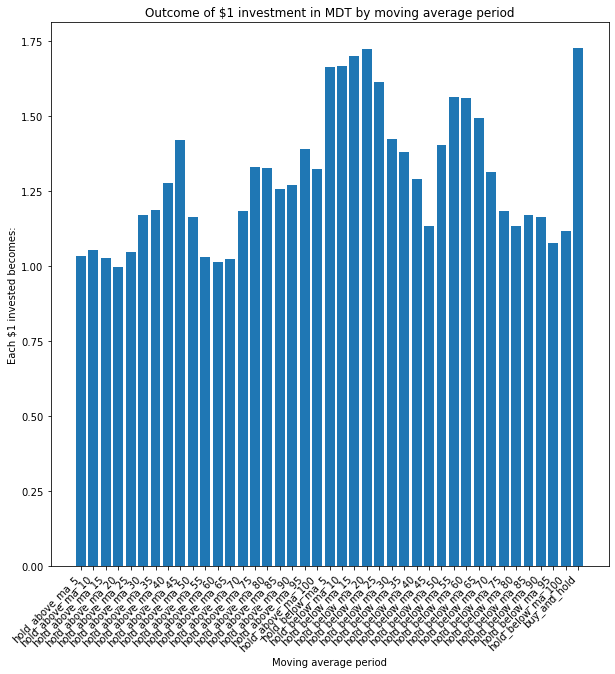

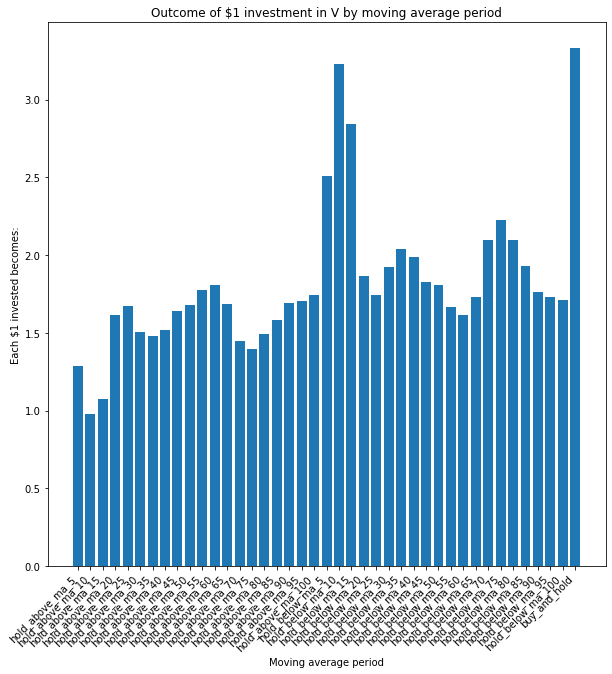

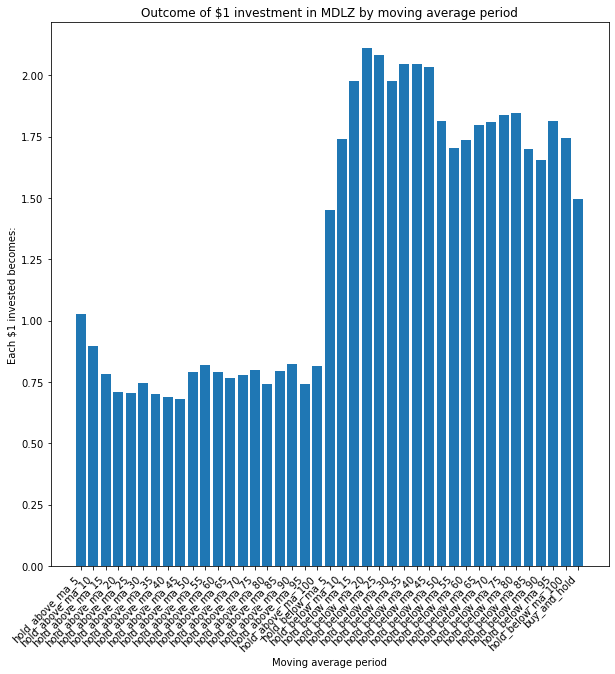

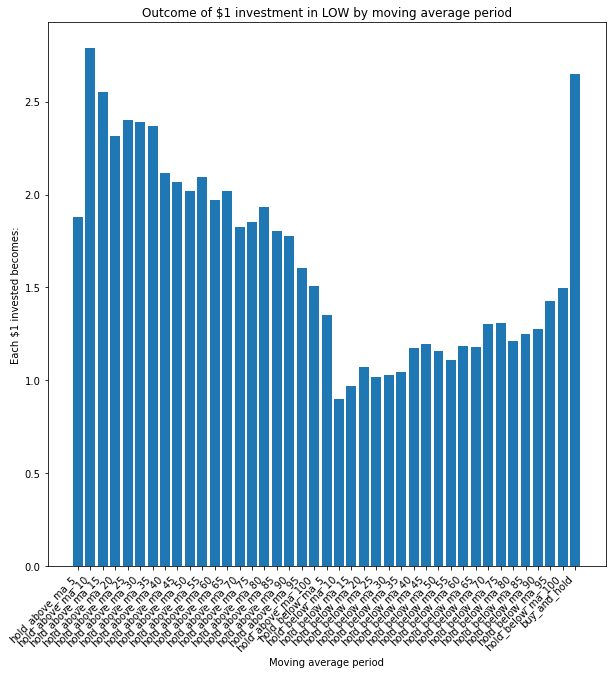

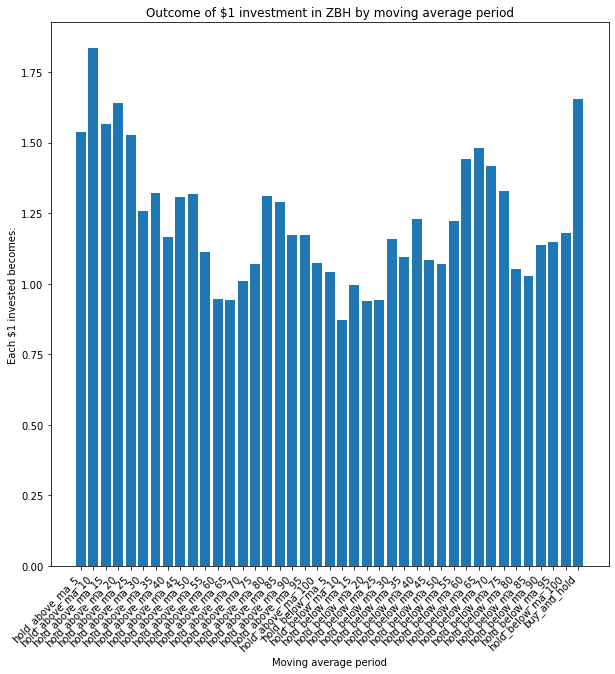

In [15]:

for i in range (0, 5): # i.e. for each column in ma_df_table 
    xset = [] # xset will store a list of moving average strategies.
    for j in range(0, len(ma_df_table)):        
        xset.append(ma_df_table.index[j])
    yset=ma_df_table.iloc[:,i]
    plt.figure(figsize=(10,10)) # From https://stackabuse.com/change-figure-size-in-matplotlib/ # enlarging the
    # graph was necessary in order to make all the data and text visible.
    plt.bar(xset,yset)
    plt.xticks(rotation=45, ha="right") # Makes the tick labels easier to read by rotating them horizontally. From
    # https://stackoverflow.com/a/48490202/13097194
    plt.xlabel("Moving average period")
    plt.ylabel("Each $1 invested becomes:")
    title = "Outcome of $1 investment in "+ma_df_table.columns[i].split('_')[0]+" by moving average period" 
    # ma_df_table.columns[i].split('_')[0]
    # converts each column title (e.g. "MDT_$1_becomes" into the stock ticker (e.g. "MDT").
    plt.title(title)
    plt.show()

11. Next, I'll plot all the outcomes of each moving average strategy for each stock in a single graph. This makes it
easier to determine which moving average strategies work particularly well (or poorly) across multiple stocks.

<AxesSubplot:title={'center':'Outcome of investing $1 in 5 different stocks using different investment strategies'}, xlabel='Moving average period', ylabel='Each $1 invested becomes:'>

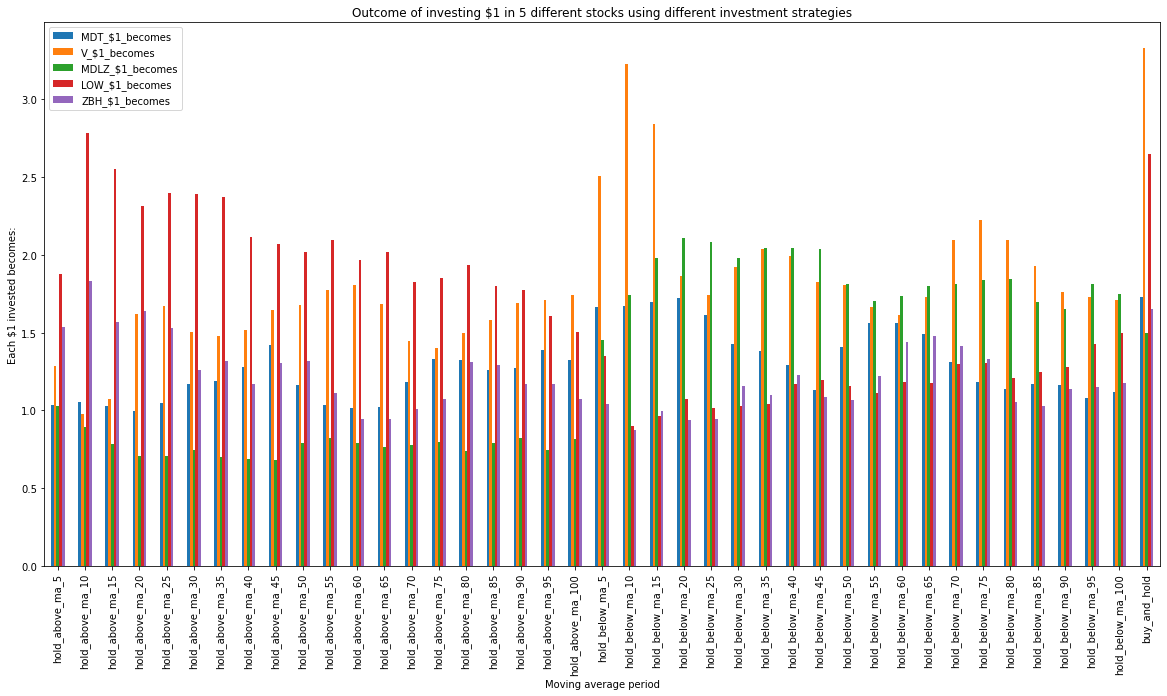

In [16]:
ma_df_table.plot(kind='bar',figsize=(20,10), xlabel="Moving average period", ylabel = "Each $1 invested becomes:",
                title="Outcome of investing $1 in 5 different stocks using different investment strategies") 
# Enlarging the graph made it easier to display all the bars in a readable format.


12. The code below prints which investing strategy worked best for each stock.

In [17]:
for i in range(0,len(ma_df_table.columns)): # i.e. for each stock in ma_df_table
    print("For",ma_df_table.columns[i].split('_')[0]+", the best moving average to select is", 
          str(ma_df_table.iloc[:,i].idxmax())+ ".") # This line, based on 
    # https://stackoverflow.com/a/10202789/13097194 , uses idxmax to find the index value that 
    # corresponds to the highest value within each column. str() has to be used on idxmax() in order for Python 
    # to recognize the + as concatenation rather than an integer + string addition attempt.


For MDT, the best moving average to select is buy_and_hold.
For V, the best moving average to select is buy_and_hold.
For MDLZ, the best moving average to select is hold_below_ma_20.
For LOW, the best moving average to select is hold_above_ma_10.
For ZBH, the best moving average to select is hold_above_ma_10.


13. Finally, I will visualize a graph of the outcomes over time for three different strategies (hold above the 50-day moving average; hold below the 50-day moving average; and buy and hold) for one of the stocks in the list. First, I will create a copy of the V (Visa) close price DataFrame from df_list. I will then add a column to store V's 50-day moving average, along with columns that will ultimately store the outcomes of the 3 different strategies. 

In [18]:
df_v = df_list[1].copy()
df_v = add_moving_avg(df_v,50)
df_v['hold_above_ma_cash'] = 1 # Each strategy will start with $1 in cash; therefore, for each strategy, 
# I will initialize a column of 1s. The next set of code will modify these cash values based on the three 
# different trading strategies.
df_v['hold_below_ma_cash'] = 1
df_v['buy_&_hold']=1
df_v

,V_close,pct_change,50_day_ma,close_above_50_day_ma,hold_above_ma_cash,hold_below_ma_cash,buy_&_hold
date,,,,,,,
2016-05-19,74.499300,-0.007103,74.392274,True,1,1,1
2016-05-20,75.264836,0.010276,74.539120,True,1,1,1
2016-05-23,74.819081,-0.005922,74.649774,True,1,1,1
2016-05-24,76.921884,0.028105,74.805193,True,1,1,1
2016-05-25,76.611793,-0.004031,74.946284,True,1,1,1
...,...,...,...,...,...,...,...
2021-03-05,215.410000,0.018487,208.333732,True,1,1,1
2021-03-08,220.270000,0.022562,208.628577,True,1,1,1
2021-03-09,220.360000,0.000409,208.936004,True,1,1,1


14. The following code outputs the returns from each trading strategy for each day in the simulation. The for loops used, which are similar to 
those used in the trade_strategy and buy_and_hold functions, store the current day's cash values at the close of each day. This allows for each 
strategy's returns to be compared over time.

In [19]:
# Buy and hold strategy
for i in range(1, len(df_v)): # i represents the different dates stored in df_v
    df_v.iloc[i,6] = df_v.iloc[i-1, 6] * (1 + df_v.iloc[i,1]) # iloc[i, 6] refers to the cell within the 
    # buy_&_hold column for the current date; iloc[i-1, 6] refers to the previous date within the same column.
    # iloc[i, 1] represents the current day's percentage change.

for i in range(1, len(df_v)): # Buy and hold above moving average strategy
    if df_v.iloc[i-1,3] == True: # iloc[i-1, 3] displays whether or not the stock closed above 
        # its 50-day moving average yesterday.
        df_v.iloc[i,4] = df_v.iloc[i-1, 4] * (1 + df_v.iloc[i,1]) 
        # iloc[i, 4] refers to the cell within the hold_above_ma cash for the current date
    else:
      df_v.iloc[i,4] = df_v.iloc[i-1,4] # i.e. if the stock did not close above its 50-day moving average, 
    # store the previous day's cash value as the current day's cash value, which represents the fact that
    # the cash is not currently invested in the stock. 

for i in range(1, len(df_v)): # Buy and hold below moving average strategy
    if df_v.iloc[i-1,3] == False:
        df_v.iloc[i,5] = df_v.iloc[i-1, 5] * (1 + df_v.iloc[i,1]) 
        # iloc[i, 5] refers to the cell within the hold_below_ma column for the current date
    else:
        df_v.iloc[i,5] = df_v.iloc[i-1,5]

df_v

,V_close,pct_change,50_day_ma,close_above_50_day_ma,hold_above_ma_cash,hold_below_ma_cash,buy_&_hold
date,,,,,,,
2016-05-19,74.499300,-0.007103,74.392274,True,1.000000,1.000000,1.000000
2016-05-20,75.264836,0.010276,74.539120,True,1.010276,1.000000,1.010276
2016-05-23,74.819081,-0.005922,74.649774,True,1.004292,1.000000,1.004292
2016-05-24,76.921884,0.028105,74.805193,True,1.032518,1.000000,1.032518
2016-05-25,76.611793,-0.004031,74.946284,True,1.028356,1.000000,1.028356
...,...,...,...,...,...,...,...
2021-03-05,215.410000,0.018487,208.333732,True,1.598825,1.808476,2.891437
2021-03-08,220.270000,0.022562,208.628577,True,1.634897,1.808476,2.956672
2021-03-09,220.360000,0.000409,208.936004,True,1.635565,1.808476,2.957880


15. I can now create a graph that shows how the cash invested in Visa using these three different strategies changes over time. These results 
indicate that a "hold above ma" moving strategy can help protect against losses (note how the losses from early 2020 were muted for "hold above 
ma" compared to the other two strategies). They also show that, when a stock rises over a time period, an investor using the "hold below ma" 
strategy will hold the stock for a relatively low proportion of time. Ultimately, however, the buy and hold strategy was by far the best option 
in this case.

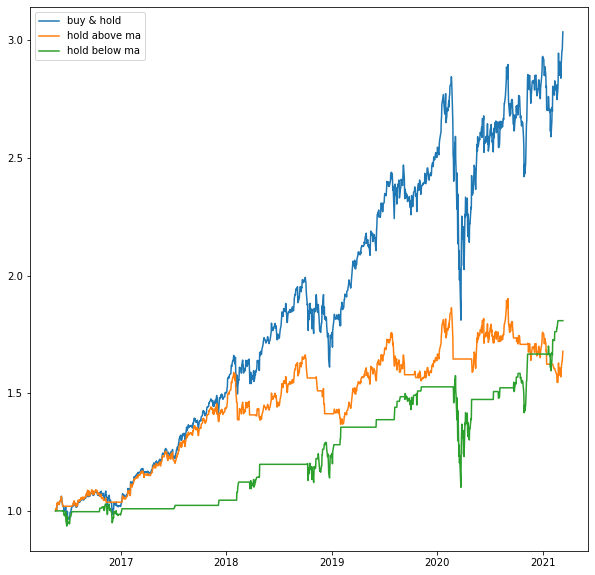

In [20]:
plt.figure(figsize=(10,10))
xset = df_v.index
yset = df_v['buy_&_hold']
yset2 = df_v['hold_above_ma_cash']
yset3 = df_v['hold_below_ma_cash']
plt.plot(xset,yset, label = "buy & hold") 
# Used https://stackoverflow.com/a/19125863/13097194 to set labels and display legend
plt.plot(xset, yset2, label = "hold above ma")
plt.plot(xset, yset3, label = "hold below ma")
plt.legend(loc="upper left") 
plt.show()

16. 

The results from this program show that moving average strategies *can* beat buy-and-hold strategies. However, for 4 out of the 5 stocks I 
analyzed, the buy-and-hold strategy was the best, or one of the best options. This may be because the stock market has done very well in the last 
5 years, which limits the value of a moving strategy's ability to time entrances and exits into a stock.

To gain more insights into the value of different moving average strategies, I decided to evaluate these strategies over a 21-year period for an 
asset (SPY) that represents the SP500. 

First, I used get_clean_df to create a DataFrame for our SPY data.

**Note: The following code block may return an error if it has been less than one minute since Alpha Vantage retrieved data for the 5 stocks above. (This is due to the limitations Alpha Vantage imposes on its free API.) If thiis error occurs, just wait until a minute has passed, then rerun the code.**



In [21]:
df_spy = get_clean_df('SPY',rowcount=0,rowlimit=False)
df_spy 


,SPY_close,pct_change
date,,
1999-11-01,91.209265,NaN
1999-11-02,90.557439,-0.007146
1999-11-03,91.167214,0.006734
1999-11-04,91.861030,0.007610
1999-11-05,92.765163,0.009842
...,...,...
2021-03-05,383.630000,0.018397
2021-03-08,381.720000,-0.004979
2021-03-09,387.170000,0.014277


17. Next, I used evaluate_ma_options to see how much cash an investor who entered $1 into SPY would end up with using the various moving average 
strategies discussed above.

In [22]:
ma_df_spy = pd.DataFrame(evaluate_ma_options(df_spy))
ma_df_spy.set_index('ma',inplace=True)
ma_df_spy

,SPY_$1_becomes
ma,
hold_above_ma_5,0.709644
hold_above_ma_10,1.267115
hold_above_ma_15,1.427815
hold_above_ma_20,1.806558
hold_above_ma_25,1.590502
hold_above_ma_30,2.190527
hold_above_ma_35,2.052195
hold_above_ma_40,1.507406
hold_above_ma_45,1.538307


18. The table shows that, although the best strategy over this time period was hold_below_ma_5, the second-best strategy was buy_and_hold. The 
bar graph below represents this as well:

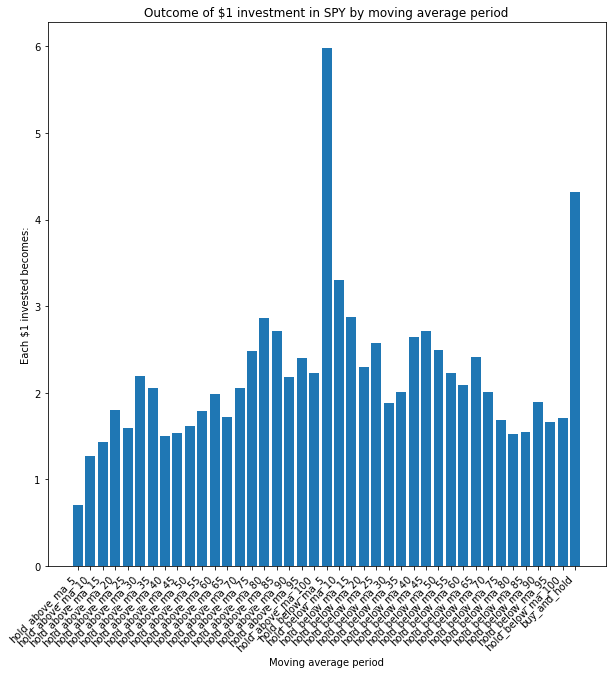

In [23]:
xset = [] # xset will store a list of moving average strategies.
for j in range(0, len(ma_df_table)):        
    xset.append(ma_df_spy.index[j])
yset=ma_df_spy["SPY_$1_becomes"]
plt.figure(figsize=(10,10)) # From https://stackabuse.com/change-figure-size-in-matplotlib/ #
# enlarging the graph was necessary in order to make 
# all the data and text visible.
plt.bar(xset,yset)
plt.xticks(rotation=45, ha="right") # Makes the tick labels easier to read by rotating them horizontally. From 
# https://stackoverflow.com/a/48490202/13097194 ; matplotlib documentation can be found at https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html and https://matplotlib.org/stable/api/text_api.html#matplotlib.text.Text
plt.xlabel("Moving average period")
plt.ylabel("Each $1 invested becomes:")
title = "Outcome of $1 investment in SPY by moving average period"
plt.title(title)
plt.show()

19. Next, just as I did with Visa, I will create a table and a graph for SPY that compare the outcomes of the 50-day buy_above_ma and 
buy_below_ma strategies to the returns from the buy and hold strategies.

In [24]:
df_spy_ma = add_moving_avg(df_spy,50)
df_spy_ma['hold_above_ma_cash'] = 1 
df_spy_ma['hold_below_ma_cash'] = 1
df_spy_ma['buy_&_hold']=1
df_spy_ma

,SPY_close,pct_change,50_day_ma,close_above_50_day_ma,hold_above_ma_cash,hold_below_ma_cash,buy_&_hold
date,,,,,,,
2000-01-11,97.459412,-0.011966,95.319368,True,1,1,1
2000-01-12,96.489876,-0.009948,95.424980,True,1,1,1
2000-01-13,97.796641,0.013543,95.569764,True,1,1,1
2000-01-14,99.124453,0.013577,95.728909,True,1,1,1
2000-01-18,98.344640,-0.007867,95.858581,True,1,1,1
...,...,...,...,...,...,...,...
2021-03-05,383.630000,0.018397,381.174400,True,1,1,1
2021-03-08,381.720000,-0.004979,381.464000,True,1,1,1
2021-03-09,387.170000,0.014277,381.856000,True,1,1,1


In [25]:
# Buy and hold strategy
for i in range(1, len(df_spy_ma)): # i represents the different dates stored in df_spy_ma
    df_spy_ma.iloc[i,6] = df_spy_ma.iloc[i-1, 6] * (1 + df_spy_ma.iloc[i,1]) 

for i in range(1, len(df_spy_ma)): # Buy and hold above moving average strategy
    if df_spy_ma.iloc[i-1,3] == True: 
        df_spy_ma.iloc[i,4] = df_spy_ma.iloc[i-1, 4] * (1 + df_spy_ma.iloc[i,1]) 
    else:
      df_spy_ma.iloc[i,4] = df_spy_ma.iloc[i-1,4] 
for i in range(1, len(df_spy_ma)): 
    if df_spy_ma.iloc[i-1,3] == False:
        df_spy_ma.iloc[i,5] = df_spy_ma.iloc[i-1, 5] * (1 + df_spy_ma.iloc[i,1]) 
    else:
        df_spy_ma.iloc[i,5] = df_spy_ma.iloc[i-1,5]

df_spy_ma

,SPY_close,pct_change,50_day_ma,close_above_50_day_ma,hold_above_ma_cash,hold_below_ma_cash,buy_&_hold
date,,,,,,,
2000-01-11,97.459412,-0.011966,95.319368,True,1.000000,1.000000,1.000000
2000-01-12,96.489876,-0.009948,95.424980,True,0.990052,1.000000,0.990052
2000-01-13,97.796641,0.013543,95.569764,True,1.003460,1.000000,1.003460
2000-01-14,99.124453,0.013577,95.728909,True,1.017084,1.000000,1.017084
2000-01-18,98.344640,-0.007867,95.858581,True,1.009083,1.000000,1.009083
...,...,...,...,...,...,...,...
2021-03-05,383.630000,0.018397,381.174400,True,1.577444,2.495369,3.936305
2021-03-08,381.720000,-0.004979,381.464000,True,1.569591,2.495369,3.916707
2021-03-09,387.170000,0.014277,381.856000,True,1.592000,2.495369,3.972628


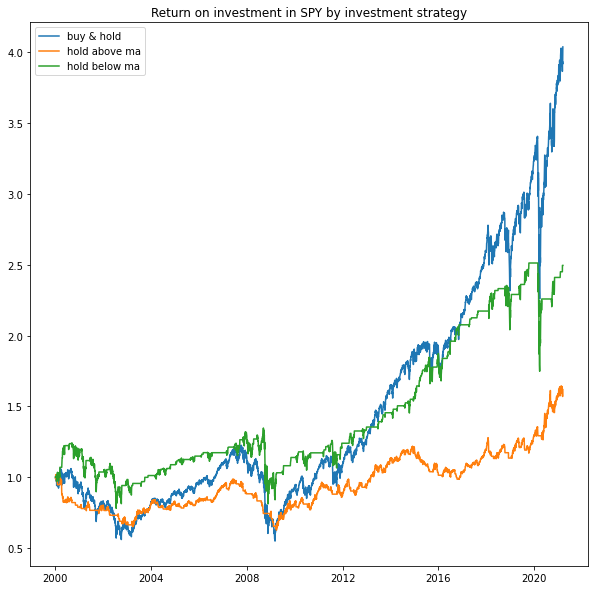

In [26]:
plt.figure(figsize=(10,10))
xset = df_spy_ma.index
yset = df_spy_ma['buy_&_hold']
yset2 = df_spy_ma['hold_above_ma_cash']
yset3 = df_spy_ma['hold_below_ma_cash']
plt.plot(xset,yset, label = "buy & hold") 
plt.plot(xset, yset2, label = "hold above ma")
plt.plot(xset, yset3, label = "hold below ma")
plt.legend(loc="upper left") 
title = "Return on investment in SPY by investment strategy"
plt.title(title)
plt.show()

Therefore, even for a longer time period and an index fund, the buy_and_hold strategy outperformed almost all moving average strategies. 